In [1]:
import pandas as pd
import yaml
import numpy as np
from datetime import date
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

import matplotlib.pyplot as plt
from scipy import signal
from src.sim_utils_Jax import *
from src.plot_utils import *
import src.vncNetParallel as vncNetParallel

In [5]:
simStr = "mancBDN2activation_3_n=250"
defaultParamPath = "../configs/20250122_mancBDN2activation.yaml"
useSeed = True

with open(defaultParamPath, 'r') as file:
    defaultParams = yaml.safe_load(file)
params = defaultParams

In [6]:
nSims = 250
params["seed"] = np.random.randint(100000,size=nSims).tolist()

# SAVE MODIFIED PARAM FILE
dateStr = date.today().strftime(format="%Y%m%d")
saveStr = dateStr+"_"+simStr
params["name"] = saveStr
fullConfigPath = f"../configs/{saveStr}.yaml"

with open(fullConfigPath,"w") as outfile:
    yaml.dump(params,outfile)

In [7]:
Rs, params_arr, params = run_sim_from_params(params)
save_sim_data(Rs,params)

250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


start run
Time to solve system vmap: 174.71187925338745


In [9]:
for i in range(nSims): #range(nSims):
    os.system(f"tsp python {os.path.abspath('../src/run_from_config.py')} '{fullConfigPath}' --idx {i}")

33
34
35
36
37


0.017622319332959
4561


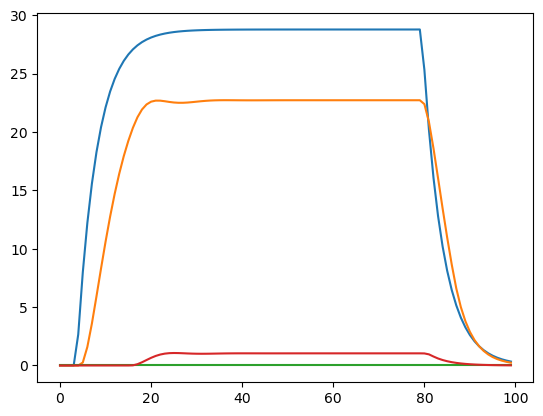

In [38]:
Rsjax = np.load("../results/jax/20250211_mancBDN2pruning/20250211_mancBDN2pruning_iter114/Rs.npy")
Rjax = Rsjax[0]
Rtsp = np.load("../results/tsp/20250211_mancBDN2pruning_0/20250211_mancBDN2pruning_0_iter114/R.npy")

#print(np.sum((Rjax - Rtsp)**2))

wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
#plot_R_traces(Rjax,nonMns,activeOnly=False)


for i in nonMns.index:
    plt.plot(Rjax[i])
    #plt.plot(Rtsp[i])


print(np.sum(Rjax - Rtsp)**2)

"""
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index

maxFrsJax = np.max(Rjax,axis=1)
activeMnIdxsJax = mnIdxs[np.where(maxFrsJax[mnIdxs]>0)]

maxFrsTsp = np.max(Rjax,axis=1)
activeMnIdxsTsp = mnIdxs[np.where(maxFrsTsp[mnIdxs]>0)]

start=0
end=len(Rjax[0])

oscillationScoreJax = sim_oscillation_score(Rjax,activeMnIdxsJax,start,end)
oscillationScoreTsp = sim_oscillation_score(Rjax,activeMnIdxsTsp,start,end)
print(oscillationScoreJax, oscillationScoreTsp)
"""
print(len(wTable))


In [10]:
maxFrs = np.max(Rtsp,axis=1)
wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
allNeurons = wTable.index.to_numpy()
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index
inIdxs = np.setdiff1d(allNeurons,mnIdxs.to_numpy())
silentINs = np.intersect1d(np.where(maxFrs==0)[0],inIdxs)

print(np.any(silentINs == 1509))

False


In [11]:
def removal_probability(maxFrs,neuronsToExclude=[]):
    """assign a probability of removal to each neuron based on their max FR"""
    tmp = 1/maxFrs
    tmp[~np.isfinite(tmp)] = 0
    tmp[neuronsToExclude] = 0
    p = tmp/sum(tmp)

    return p

neuronsPutBack = []

p = removal_probability(maxFrs[inIdxs],neuronsToExclude=np.in1d(inIdxs,np.union1d(neuronsPutBack,[])))
print(inIdxs[np.argmax(p)])

1509


/tmp/ipykernel_2710195/400103285.py:3: RuntimeWarning: divide by zero encountered in divide
  tmp = 1/maxFrs


In [3]:
Rs0 = np.load("../results/jax/20250209_mancBDN2activation_0/20250209_mancBDN2activation_0/Rs.npy")
Rs1 = np.load("../results/jax/20250209_mancBDN2activation_1/20250209_mancBDN2activation_1/Rs.npy")
Rs2 = np.load("../results/jax/20250209_mancBDN2activation_2/20250209_mancBDN2activation_2/Rs.npy")
Rs3 = np.load("../results/jax/20250209_mancBDN2activation_3/20250209_mancBDN2activation_3/Rs.npy")
print('loaded')

Rs = np.concatenate((Rs0, Rs1, Rs2, Rs3))

print(Rs0.shape)

loaded
(250, 4561, 1000)


In [4]:
def load_params(paramPath):
    with open(paramPath, 'r') as file:
        defaultParams = yaml.safe_load(file)
    return defaultParams

def get_sampled_params(i):
    paramPath = f'../results/jax/20250209_mancBDN2activation_{i}/20250209_mancBDN2activation_{i}/params.yaml'
    params = load_params(paramPath)

    wTable = pd.read_csv(params["dfPath"],index_col=0)
    nNeurons = len(wTable)  
    print(nNeurons)
    nSims = len(params["seed"])
    print(nSims)
    stimNeurons = np.array(params["stimNeurons"])

    params_arr = vncNetParallel.generate_params_from_config(wTable, params, nSims, nNeurons, stimNeurons)
    tAxis, T, dt, input, tau, threshold, a, frCap, excSynapseMultiplier, inhSynapseMultiplier = params_arr
    return tau, threshold, a, frCap




tau0, threshold0, a0, frCap0 = get_sampled_params(0)
tau1, threshold1, a1, frCap1 = get_sampled_params(1)
tau2, threshold2, a2, frCap2 = get_sampled_params(2)
tau3, threshold3, a3, frCap3 = get_sampled_params(3)

tau = np.concatenate((tau0, tau1, tau2, tau3))
threshold = np.concatenate((threshold0, threshold1, threshold2, threshold3))
a = np.concatenate((a0, a1, a2, a3))
frCap = np.concatenate((frCap0, frCap1, frCap2, frCap3))





4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


4561
250
stim neurons: [ 31 132]


/home/jkl/vnc-closedloop/src/vncNetParallel.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/jkl/vnc-closedloop/src/vncNetParallel.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


In [5]:
wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index

print(len(Rs))
oscillationScores = np.zeros(len(Rs))
for i in range(len(Rs)):
    R = Rs[i]
    oscillationScores[i] = sim_oscillation_score(R,mnIdxs,0,1000)




1000


/home/jkl/vnc-closedloop/src/sim_utils_Jax.py:34: RuntimeWarning: invalid value encountered in divide
  activity = activity/np.max(activity)


In [1]:
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)].to_numpy()[:, 0]
print(nonMns[0])

n = 31
plt.plot(a[:,n], oscillationScores, 'o')
plt.xlabel(f'gain Neuron {n}')
plt.ylabel(f'Motor Neuron Oscillation Score')
plt.title('BDN2 Gain Parameter vs Motor Neuron Oscillation Score')

NameError: name 'wTable' is not defined

### Global Parameter Sweep

In [ ]:
paramToIter = "a"
simStr = f'mancBDN2activation_{paramToIter}_sweep'

nSims = 100
seeds = np.random.randint(100000,size=nSims).tolist()
for i in range(20):
    params = getParams(simStr, i, nSims) #Get params, add seed, batch num, etc.

    params["thresholdMean"] = 7.5
    params["seed"] = seeds

    #Reset parameter to sweep
    step = params[f'{paramToIter}']/10
    params[f'{paramToIter}'] = step + i*step
    params[f'{paramToIter}Stdv'] = params[f'{paramToIter}Stdv']/10
    save_params(params)

/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_00.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_01.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_02.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_03.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_04.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2activation_inhibitoryMultiplier_sweep/20250227_mancBDN2activation_inhibitoryMultiplier_sweep_05.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_mancBDN2ac

### Parameter Standard Deviation Sweep

In [3]:
paramToIter = "frcap"
simStr = f'mancBDN2activation_{paramToIter}_stdv_sweep'

nSims = 100
seeds = np.random.randint(100000,size=nSims).tolist()
for i in range(20):
    params = getParams(simStr, i, nSims) #Get params, add seed, batch num, etc.

    params["thresholdMean"] = 7.5 #Updated threshold based on mean sweeps
    params["seed"] = seeds

    #Reset parameter to sweep
    step = params[f'{paramToIter}Stdv']/10
    params[f'{paramToIter}Stdv'] = step + i*step
    save_params(params)

/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_00.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_01.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_02.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_03.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_04.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_05.yaml
/data/users/jkl/vnc-closedloop/configs/20250407_mancBDN2activation_frcap_stdv_sweep/20250407_mancBDN2activation_frcap_stdv_sweep_06.yaml
/data/users/jkl/vnc-closedloop/configs/20

### DNb08 StimI Sweep

In [6]:
simStr = 'mancDNb08_1400_activation'

nSims = 100
seeds = np.random.randint(100000,size=nSims).tolist()

for i in range(10):
    #stimI = 30 + 5*i
    stimI=65
    print(stimI)

    params = getParams(simStr, i, nSims) #Get params, add seed, batch num, etc.
    params["seed"] = np.random.randint(100000,size=nSims).tolist()
    params["stimI"] = stimI
    params["thresholdMean"] = 7.5
    params["stimNeurons"] = [1400]

    save_params(params)

65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_00.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_01.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_02.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_03.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_04.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_05.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_06.yaml
65
/data/users/jkl/vnc-closedloop/configs/20250414_mancDNb08_1400_activation/20250414_mancDNb08_1400_activation_07.yaml
65
/data/users/jkl/vnc-closedloop/config

### Make FANC BDN2 Config

In [3]:
wTable = pd.read_csv("../data/FANC weights/wTable_BDN2toMN_20250107_fullData.csv",index_col=0)
print(len(wTable))
BDN2_idxs = wTable.loc[wTable["w_type"]=="BDN2"].index.tolist()
print(BDN2_idxs)

wTable = pd.read_csv("../data/MANC weights/20231020_DNtoMN/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
BDN2_idxs = mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index.tolist()
print(BDN2_idxs)

803
[0]
[451, 582, 598, 626, 713, 722, 793, 848, 860, 868, 887, 917, 978, 991, 1020, 1024, 1043, 1044, 1064, 1073, 1104, 1147, 1169, 1182, 1211, 1270, 1302, 1307, 1354, 1357, 1367, 1396, 1412, 1436, 1473, 1474, 1482, 1498, 1501, 1557, 1573, 1580, 1685, 1696, 1723, 1729, 1743, 1773, 1787, 1805, 1828, 1838, 1927, 1973, 2058, 2065, 2071, 2083, 2086, 2107, 2150, 2153, 2165, 2176, 2256, 2260, 2279, 2303, 2309, 2379, 2380, 2403, 2408, 2409, 2410, 2419, 2528, 2581, 2595, 2602, 2605, 2636, 2656, 2667, 2682, 2742, 2790, 2819, 2821, 2877, 3029, 3088, 3108, 3120, 3138, 3224, 3233, 3283, 3288, 3462, 3501, 3502, 3506, 3509, 3911, 4156, 4173, 4338, 4339, 4352, 4358, 4371, 4380, 4400, 4439, 4440, 4465, 4468, 4513]


In [ ]:
paramPath = "/data/users/jkl/vnc-closedloop/configs/20250122_mancBDN2activation.yaml"
print(paramPath)

params = load_from_yaml(paramPath)

params["wPath"] = '../data/FANC weights/W_BDN2toMN_20250107.npy'
params["dfPath"] = '../data/FANC weights/wTable_BDN2toMN_20250107_fullData.csv'

wTable = pd.read_csv(params["dfPath"],index_col=0)
params["stimNeurons"] = wTable.loc[wTable["w_type"]=="BDN2"].index.tolist()
params["thresholdMean"] = 7.5
params["stimI"] = 600

dir = '/data/users/jkl/vnc-closedloop/configs'

if not os.path.exists(dir):
    os.makedirs(dir)

simName = '20250227_fancBDN2activation'
fullConfigPath = dir + f"/{simName}.yaml"
print(fullConfigPath)
    
with open(fullConfigPath,"w") as outfile:
    yaml.dump(params,outfile,sort_keys=False)



/data/users/jkl/vnc-closedloop/configs/20250122_mancBDN2activation.yaml
/data/users/jkl/vnc-closedloop/configs/20250227_fancBDN2activation.yaml


### Break Config into batches

In [2]:
configFolderPath = '/data/users/jkl/vnc-closedloop/configs/'
paramName = "20250404_mancDnActivationScreen-adjustStim-startBySize"

paramPath = configFolderPath + paramName + '.yaml'

for j in range(2,10):

    params = load_from_yaml(paramPath)
    params["screen"] = f'{paramName}_0{j}'
    params["seed"] = np.random.randint(100000,size=len(params["seed"])).tolist()

    iter = True

    batchSize = 100
    batch = 0
    while iter:
        batchParams = params.copy()
        i = batch*batchSize
        for iterParam in batchParams["paramsToIterate"]:
            if len(batchParams[iterParam][i:]) <= batchSize:
                iter = False
                batchParams[iterParam] = params[iterParam][i:]
            else:
                batchParams[iterParam] = params[iterParam][i:i+100]

        if batch < 10:
            batchParams["name"] = params["screen"] + f'_0{batch}'
        else:
            batchParams["name"] = params["screen"] + f'_{batch}'

        save_params(batchParams)

        batch += 1
    
    print()
    


/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_00.yaml
/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_01.yaml
/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_02.yaml
/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_03.yaml
/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_04.yaml
/data/users/jkl/vnc-closedloop/configs/20250404_mancDnActivationScreen-adjustStim-startBySize_02/20250404_mancDnActivationScreen-adjustStim-startBySize_02_05.yaml
/data/users/jkl/vnc-cl

### Noise to weight matrix screen

In [2]:
paramToIter = "a"
simStr = f'mancBDN2activation_W_noise'

nSims = 90
seeds = np.random.randint(100000,size=nSims).tolist()
for i in range(11):
    params = getParams(simStr, i, nSims) #Get params, add seed, batch num, etc.

    params["thresholdMean"] = 7.5
    params["seed"] = np.random.randint(100000,size=nSims).tolist()
    params["stimNeurons"] = [31]

    #Reset parameter to sweep
    step = 0.05
    params[f'stdvProp'] = i*step
    save_params(params)

/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_00.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_01.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_02.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_03.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_04.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_05.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_06.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_mancBDN2activation_W_noise/20250618_mancBDN2activation_W_noise_07.yaml
/data/users/jkl/vnc-closedloop/configs/20250618_

### Shuffle Weight Matrix

In [2]:
#paramToIter = "a"
simStr = f'mancBDN2activation_W_shuffle'

nSims = 50
seeds = np.random.randint(100000,size=nSims).tolist()
for i in range(11):
    params = getParams(simStr, i, nSims) #Get params, add seed, batch num, etc.

    params["thresholdMean"] = 7.5
    params["seed"] = np.random.randint(100000,size=nSims).tolist()
    params["stimNeurons"] = [31]

    #Reset parameter to sweep
    #step = 0.05
    #params[f'stdvProp'] = i*step
    save_params(params)

/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_00.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_01.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_02.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_03.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_04.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_05.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_06.yaml
/data/users/jkl/vnc-closedloop/configs/20250624_mancBDN2activation_W_shuffle/20250624_mancBDN2activation_W_shuffle_07.yaml
/data/users/jkl/